# Estimacion de precipitación Maxima usando distribuciones de valores extremos tipo 1

<div style="text-align: right"> Elaborado por: Edgar Barahona </div>
<div style="text-align: right"> Ingeniero Catastral y Geodesta </div>
<div style="text-align: right"> Universidad Distrital Francisco Jose de Caldas </div>
<div style="text-align: right"> Bogota, D.C., 29 de Diciembre de 2024</div>
<div style="text-align: right"> puede revisar el <a href="https://github.com/EDGAR-BARAHONA?tab=repositories">Repositorio GitHub</a> para mas  </div>

El analisis de datos historicos de precipitación puede ser de utilidad para multiples fines, desde la identificación de umbrales de infiltración, pasando por analisis de precipitación hasta análisis de valores extremos. En este caso llevaremos acabo un analisis para identificar la precipitación maxima acumulada en 24 horas; es decir la cantidad de lluvia que puede presentarse en una zona con una probilidad del 1%. Para este analisis se usaran datos de precipitacion diaria acumulada del [IDEAM](http://dhime.ideam.gov.co/atencionciudadano/) desde el año 1960 hasta el 2022. Comencemos importado las librerias necesarias.

In [117]:
#Importación de librerias

import os
from pathlib import Path
import pandas as pd
import math
import seaborn  as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r
import geopandas as gpd
from shapely.geometry import Point


Importadas las librerias necesarias, el primer lugar vamos a leer los datos de precipitación previamente descargados, *estos se encuentran en forrmato zip en la carpeta de datos de este repositorio* en caso de querer recrear el archivo solo es necesario descomprimir modificar la direccion donde estan los datos. Posteriormente se ajustan los datos  en un dataframe manteniendo los datos que son de importancia para el análisis.

In [48]:
#Lectura de archivos CSV y definición de rutas
ruta = Path(r"C:\Users\davo2\OneDrive - Procalculo Prosis S.A.S\27. GR\DatosPrecipitacion")
archivos = os.listdir(ruta)
datosCSV = [archivo for archivo in archivos if archivo.endswith('.csv')]

#Conversión de los datos de cada estación a dataframe y fusión en unico archivo
dataframes = [pd.read_csv(ruta.joinpath(archivo), low_memory=False) for archivo in datosCSV]
df = pd.concat(dataframes, ignore_index=True)

#Seleccion de atributos de interes
df = df[['CodigoEstacion', 'NombreEstacion', 'Latitud', 'Longitud', 'Altitud',
       'Categoria', 'Departamento', 'Municipio',
       'FechaInstalacion', 'FechaSuspension', 'Fecha', 'Valor']]

#Modificación y adición de atributos de interes
df["año"] = pd.to_datetime(df.Fecha).dt.year
df['Fecha'] = pd.to_datetime(df['Fecha'])
df["NombreEstacion"] = df['NombreEstacion'].astype(str)
df = df[df.año <= 2023]

df.head(5)

,CodigoEstacion,NombreEstacion,Latitud,Longitud,Altitud,Categoria,Departamento,Municipio,FechaInstalacion,FechaSuspension,Fecha,Valor,año
0,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-01,0.0,1961
1,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-02,0.0,1961
2,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-03,0.0,1961
3,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-04,0.0,1961
4,35010020,ACACIAS [35010020],3.994639,-73.765583,525,Pluviométrica,Meta,Acacías,15/04/1961 00:00,NaN,1961-04-05,0.0,1961


Ahora visualizaremos el comportamiento de la precipitación maxima anual del dataset de estaciones a lo largo del tiempo, en este caso usando las funciones de la libreria MatPlotLib

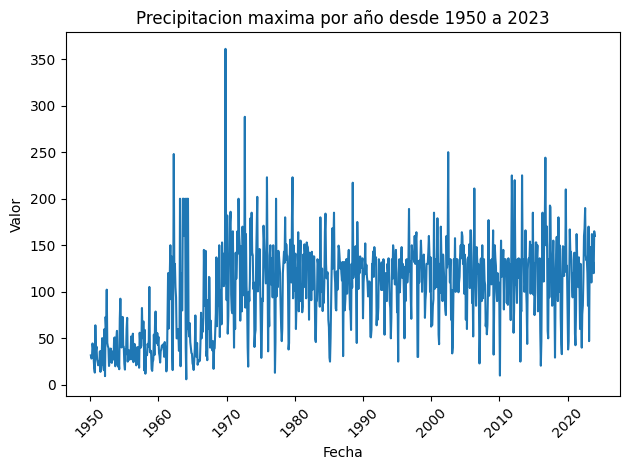

In [49]:
#Copia de dataset orifinal
dff = df.copy()

#Definición del grafico
dff.set_index([ 'Fecha'], inplace=True)
df_numeric = dff.select_dtypes(include=['number'])
df_resampled = df_numeric.resample('ME').max()
sns.lineplot(x=df_resampled.index.get_level_values('Fecha'), 
             y=df_resampled['Valor'], 
            )

#Ploteo del grafico
plt.xticks(rotation=45)
plt.title("Precipitacion maxima por año desde 1950 a 2023")
plt.tight_layout()
plt.show()


Como se observa en la grafica los valores de precipitacion maxima, muestran un comportamiento el cual se podria decir lineal a lo largo del tiempo, con un valor maximo cercano a 350mm en 24 horas, cerca al año 1970, y varios valores minimos cercanos a 30mm en 24 Horas. 

Ahora iniciaremos la codificación necesaria para el analisis. Un primer paso necesario es el proceso de imputación de datos faltantes, cuando se trabaja con datos de diferentes tipo de estaciones, como se muestra acontinuacion:

In [50]:
df.Categoria.value_counts()

Categoria
Pluviométrica          460447
Pluviográfica          193642
Climática Principal     95969
Agrometeorológica       66930
Climática Ordinaria     56518
Name: count, dtype: int64

Es muy frecuente que se presenten datos faltantes debido a multiples factores, como no medicion del dato en el momento, indisponibilidad de medición de la estación por reparación, etc. En este caso para llenar esos datos vacios se realizara un  analisis de dos pasos, el primero consiste en la identificación de los años faltantes en las series de datos del dataset de precipitación, y el segundo en el llenado de estos


Para el paso de identificacin vamos s crear dos dataset nuevos a partir del dataset de precipitaciones original. El primer dataset a crear es estaciones, el cual se crea usando el metodo *gruop_by*, este contendra los datos asociados al nombre de la estación, su longitud y latitud y su altura media sobre el nivel del mar.  

El segundo dataset se llamara precipitación y contiene el valor de precipitaciones maxima por año para cada estación, inluyendo su latiud y longitud

In [51]:
estaciones = df.groupby(by=["NombreEstacion", "Latitud", "Longitud"])["Altitud"].mean().reset_index()
precipitacion = df.groupby(by=["NombreEstacion", "Latitud", "Longitud", "año"])["Valor"].max().reset_index()

Ahora el proceso de identificación de años faltantes es el siguiente: Usando un ciclo *for* se recorre cada estación del dataset de estaciones, buscando identificar los datos del dataset de precipitaciones asociados a cada estacion. Identificados estos, se obtiene el año de  inició y final de la serie de tiempo de cada estación; ello con la finalidad de identificar si dentro de estas hay años en los que no hay datos. El fin del proceso consiste en adicionar una fila a los datos de precipitación correspondiente a los años faltantes, en los que el valor de precipitación maxima se define con un valor igual a *"-1"*

In [52]:

EstVacios =[]

#Generación nombres estaciones
Estaciones = list(df.NombreEstacion.unique())


for estacion in Estaciones:
    
    #Seleccionar datos precipitación de estación actual
    dfsel = precipitacion[precipitacion.NombreEstacion == estacion]
    
    #Identificación alos inicio y final de la serie y años faltantes
    inicio = dfsel.año.min()
    fin = dfsel.año.max()
    allaños = set(range(inicio, fin + 1))
    añosExis = set(dfsel.año)
    añosFalt = allaños-añosExis
    
    #Adicion de los campos de años vacios
    if len(añosFalt) ==0:
        pass
    else:
        EstVacios.append(estacion)
        filas_faltantes = pd.DataFrame({
        'NombreEstacion': [estacion] * len(añosFalt),
        'Latitud': [dfsel.Latitud.unique()][0][0],
        'Longitud': [dfsel.Longitud.unique()][0][0],
        'año': list(añosFalt),
        'Valor': -1
        })

        precipitacion = pd.concat([precipitacion, filas_faltantes])
        
precipitacion = precipitacion.reset_index(drop=True)
    

Ahora visualizaremos el resultado del proceso para los datos de la estacion *EL CALVARIO [35030010]* en donde se ve que se crearon registro entre los años 1967 a 1989.

In [53]:
precipitacion[precipitacion['NombreEstacion']== 'EL CALVARIO [35030010]'].sort_values('año').head(25)

,NombreEstacion,Latitud,Longitud,año,Valor
463,EL CALVARIO [35030010],4.35259,-73.71319,1968,51.0
1854,EL CALVARIO [35030010],4.35259,-73.71319,1969,-1.0
1855,EL CALVARIO [35030010],4.35259,-73.71319,1970,-1.0
1856,EL CALVARIO [35030010],4.35259,-73.71319,1971,-1.0
1857,EL CALVARIO [35030010],4.35259,-73.71319,1972,-1.0
1858,EL CALVARIO [35030010],4.35259,-73.71319,1973,-1.0
1859,EL CALVARIO [35030010],4.35259,-73.71319,1974,-1.0
1860,EL CALVARIO [35030010],4.35259,-73.71319,1975,-1.0
1861,EL CALVARIO [35030010],4.35259,-73.71319,1976,-1.0
1862,EL CALVARIO [35030010],4.35259,-73.71319,1977,-1.0


Ahora procederemos a la imputación de los datos nulos, en primer caso definimops una function llamada **calcular_distancia**, la cual tendra la finalidad de calcular la distancia entre dos estaciones unsando la formula de [Haversine](https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/) la cual mide la distancia teniendo en cuenta la circurferencia de la tierra.

In [54]:
def calcular_distancia(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros
    R = 6371.0

    # Convertir las coordenadas de grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Diferencias entre las coordenadas
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Fórmula de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distancia
    distance = R * c

    return distance

Ahora se procedera a imputar un valor a los datos de las estaciones con años faltantes, en este caso usando la varaible *EstVacios* que describe el nombre de las estaciones en las cuales hay datos faltantes. El proceso se basa en validar para cada una de las estaciones con faltantes, su cercania con las demas estaciones y usando las seis estaciones mas cercanas asignar un valor de precipitacion maxima a partir de un proceso de interpolación usando el metodo [IDW](https://pro.arcgis.com/es/pro-app/latest/help/analysis/geostatistical-analyst/how-inverse-distance-weighted-interpolation-works.htm).

In [55]:
for estacion in EstVacios:
    
    #Identificación de años adicionados
    for idx in precipitacion[(precipitacion.NombreEstacion == estacion) & (precipitacion.Valor == -1)].index:
        año = precipitacion.loc[idx, 'año']
        
        #Identificación de las estaciones cercanas usando la función de distancia y seleccion de las seis mas cercanas
        EstCercanas = estaciones[estaciones.NombreEstacion != estacion].copy()
        EstCercanas["Lat"] = estaciones[estaciones.NombreEstacion == estacion]["Latitud"].values[0]
        EstCercanas["Lon"] = estaciones[estaciones.NombreEstacion == estacion]["Longitud"].values[0]
        EstCercanas['distancia'] = EstCercanas.apply(lambda row: calcular_distancia(row['Latitud'], row['Longitud'], row['Lat'], row['Lon']), axis=1)
        EstCercanasSel = list(EstCercanas.sort_values(by="distancia")["NombreEstacion"].head(6))

        #Obtener los datos de precipitacion de las estacionees cercanas a la estacion de interes que concuerden con el mismo año.
        precipitacion_filtradas = precipitacion[(precipitacion['NombreEstacion'].isin(EstCercanasSel)) & (precipitacion['año'] == año)]
        
        #creación de dataset temporal para análisis
        merged_df = precipitacion_filtradas.merge(EstCercanas[["NombreEstacion","distancia"]], on = 'NombreEstacion', how = 'inner')
        
        #adicion de dato faltante por medio del metodo IDW
        merged_df["alfa"] = (1/pow(merged_df.distancia,2))/sum(1/pow(merged_df.distancia,2))
        estimado = sum(merged_df.Valor*merged_df.alfa)

        precipitacion.loc[idx, "Valor"] = estimado

Ahora veamos el resultado del proceso de imputación sobre los datos faltantes de la estación *EL CALVARIO [35030010]*.

In [56]:
precipitacion[precipitacion['NombreEstacion']== 'EL CALVARIO [35030010]'].sort_values('año').head(25)

,NombreEstacion,Latitud,Longitud,año,Valor
463,EL CALVARIO [35030010],4.35259,-73.71319,1968,51.000000
1854,EL CALVARIO [35030010],4.35259,-73.71319,1969,123.291990
1855,EL CALVARIO [35030010],4.35259,-73.71319,1970,86.290015
1856,EL CALVARIO [35030010],4.35259,-73.71319,1971,141.584869
1857,EL CALVARIO [35030010],4.35259,-73.71319,1972,227.878134
1858,EL CALVARIO [35030010],4.35259,-73.71319,1973,144.792188
1859,EL CALVARIO [35030010],4.35259,-73.71319,1974,125.016834
1860,EL CALVARIO [35030010],4.35259,-73.71319,1975,168.837189
1861,EL CALVARIO [35030010],4.35259,-73.71319,1976,112.407070
1862,EL CALVARIO [35030010],4.35259,-73.71319,1977,108.709850


Hasta este púnto hemos tratados los datos faltantes en las series de tiempo mediante metodos de interpolación, el siguiente paso consiste en la estimación del valor de precipitación maxima para un periodo de retorno de 100 años. En este caso se implementara la [distribución gumbel o distribución de valores extremos tipo I](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_r.html#scipy.stats.gumbel_r) mediante la libreria Scipy.stats.

El proceso de analisis es el siguiente: En primer paso se agregan 3 nuevos campos al dataset de estaciones que fue creado con anteriridad:

- los cuales representan el valor predicho asociado a la precipitacion maxima para el periodo de retorno de 100 años.
- El ajuste de los datos de cada estación a la distribución Gumbel.
- El valor de R2 que indica el coehficiente de determinación para el ajuste a la distribución.

Posterirmente para cada estación se calculan los valores $\alpha$ y $\mu$ que son obtenidos mediante el metodo fit la funcion gumbel_r (*gumbel_r.fit*). Estimados los valores de *mu* y *beta* se procede a calcular el valor de la precipitación $( X_T )$  para un periodo de retorno de 100 años para cada estación mediante la siguiente formula:

$$
X_T = \mu - \alpha \cdot \ln\left(-\ln\left(1 - \frac{1}{T}\right)\right)
$$

donde:
- $\mu$: Parámetro de localización.
- $\alpha$: Parámetro de escala.
- $T$: Período de retorno.

Como siguiente paso se calculan los valores de los factores de ajuste, para el caso la validación se realiza por medio del el test de kolmogorov smirnov y el factor de ajuste $R^2$. El analisis e los datos se basa en verificar si estos se ajustan a la distribución gumbel, ello mediante el test de Kolmogorv; que consiste en comparar un valor Delta, obtenido como la diferencia maxima entre la distribución teorica gumbel y una distribución empirica u observada definida por la siguiente expresión:

$$
F_{\text{emp}}(x_i) = \frac{m}{n+1}
$$

Donde $m$ es el valor de la posición del $x_i$ registro de precipitación y $n$ es el numero total de registros en cada serie de datos. El maximo valor en la diferencia entre la distribución empirica y teorica se compara con un valor previamente establecido de la siguiente forma : 

$$

si, D_c < D_t \ Acepta \ H_0 \\
si, D_c > D_t \ Rechaza \ H_0\\
\\
D_c : Maxima \ diferencia \ identificada\\
D_t : Valor \ de \ referencia \ en \ tablas \ estadisticas

$$


Si $D_c < D_t$ se infiere que no hay información necesaria para negar la hipotesis nula $H_0$ y por ende se asume que los datos se ajustan a la distribución Gumbel, en caso contrario, si $D_c > D_t$ se asume que los datos no se ajustan a la distribución mencionada. Por ultimo se calcula el coehficiente de de determinacion $R^2$ el cual indica la proporción de la variación de las frecuencias empiricas se explica por la frecuencias teoricas acumuladas; en pocas palabras la relación entre las distribuciones calculadas.

$$
R^2 = 1 - \frac{\sum_{i=1}^n \left(F_{\text{e}}(x_i) - F_{\text{t}}(x_i)\right)^2}{\sum_{i=1}^n \left(F_{\text{e}}(x_i) - \overline{F_{\text{e}}(x_i)}\right)^2}
$$

donde $R^2$ es el coheficiente de determinacion $(0<R^2<1)$, $F_{\text{e}}(x_i)$ es la frecuencia acumulada empirica para el valor $x_i$, $F_{\text{t}}(x_i)$ es la frecuencia acumulada teorica para el valor $x_i$ y $\overline{F_{\text{e}}(x_i)}$ es la media de las frecuencias empiricas acumuladas. Las metricas obtenidas del procesos de validación se añaden al dataset de estaciones elaborado previamente, ello con la finalidad de obtener un dataset final con las validación por estación.

In [79]:
precipitacion = precipitacion.sort_values(by=["NombreEstacion", "año"]).reset_index(drop=True)

#Valores a adicionar
estaciones["Predicho"] = 0
estaciones["Ajuste"] = 0
estaciones["R2"] = ""
ajuste = 0

for estacion in Estaciones:
    
    #Obtencion de metricas estadisticas
    data = precipitacion[precipitacion.NombreEstacion == estacion]["Valor"]
    N = len(data) #Largo
    miu, alfa = gumbel_r.fit(data) #Valores de la distribución gumbel
    media = data.mean() #Media
    varianza = sum(pow(data - data.mean(),2))/(N-1) #
    
    #Predicción de los valores de precipitación con retorno de 100 años
    VPREDICT = miu + alfa*(-np.log(np.log(100/99)))

    #Calculo factores de ajuste

    PEMPIRICA = np.zeros(N)
    for i in range(N):
        PEMPIRICA[i] = i/(N+1)

    VECTORA = np.sort(data)

    PACUMULADA = np.zeros(N)
    for i in range(N):
        PACUMULADA[i] = np.exp(-np.exp(-(VECTORA[i] - miu) /alfa))

    delta = abs(PEMPIRICA - PACUMULADA)
    DELTA = np.sort(delta)[::-1]

    VECTORC = np.array([0.97500, 0.84189, 0.70760, 0.62394, 0.56328, 0.51926, 0.48342, 0.45427, 0.43001, 0.40925,
                    0.39122, 0.37543, 0.36143, 0.34890, 0.33750, 0.32733, 0.31796, 0.30936, 0.30143, 0.29408,
                    0.28724, 0.28087, 0.2749, 0.26931, 0.26404, 0.25908, 0.25438, 0.24993, 0.24571, 0.24170,
                    0.23788, 0.23424, 0.23076, 0.22743, 0.22425, 0.22119, 0.21826, 0.21544, 0.21273, 0.21012,
                    0.20760, 0.20517, 0.20283, 0.20056, 0.19837, 0.19625, 0.19420, 0.19221, 0.19028, 0.18841])

    if N<51:
        DELTAT = VECTORC[N-1]
    else:
        DELTAT = 1.36/math.sqrt(N)

    if DELTAT > DELTA[0]:
        ajuste = "SI"
    else:
        ajuste = "NO"
            
    R1  = np.zeros(N)
    R2 = np.zeros(N)
    
    for i in range(N):
        R1[i] = pow(PEMPIRICA[i] -PACUMULADA[i], 2)
        R2[i] = pow(PEMPIRICA[i] - np.mean(PEMPIRICA),2)
    RCUA = 1-(np.sum(R1)/np.sum(R2))

    estaciones.loc[estaciones.NombreEstacion == estacion, "Predicho"] = VPREDICT
    estaciones.loc[estaciones.NombreEstacion == estacion, "Ajuste"] = ajuste
    estaciones.loc[estaciones.NombreEstacion == estacion, "R2"] = RCUA

C:\Users\davo2\AppData\Local\Temp\ipykernel_2476\3143892287.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '265.68677735571583' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  estaciones.loc[estaciones.NombreEstacion == estacion, "Predicho"] = VPREDICT
C:\Users\davo2\AppData\Local\Temp\ipykernel_2476\3143892287.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NO' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  estaciones.loc[estaciones.NombreEstacion == estacion, "Ajuste"] = ajuste


Ahora veamos los resultados en el dataset de estaciones, en el cual se añaden los campos mencionados con sus valores correspondientes.

In [102]:
estaciones

,NombreEstacion,Latitud,Longitud,Altitud,Predicho,Ajuste,R2
0,ACACIAS [35010020],3.994639,-73.765583,525.0,265.686777,NO,0.83091
1,AUSTRALIA [21201300],4.394250,-74.132000,3050.0,62.224064,SI,0.956901
2,BETANIA [35020350],4.218889,-74.146861,3150.0,69.775544,SI,0.976378
3,CASITA LA [21201120],4.633333,-74.016667,3045.0,106.157354,SI,0.964128
4,CAÑO HONDO [35010040],3.925070,-73.813620,639.0,245.893616,SI,0.97437
5,CHIPAQUE [35020050],4.450000,-74.050000,2850.0,61.529602,SI,0.973427
6,CHOACHI [35020240],4.533333,-73.933333,1950.0,63.299286,SI,0.985791
7,CHOACHI [35020280],4.522917,-73.926583,1950.0,80.671294,SI,0.971066
8,CLARAVAL [35060210],4.650250,-73.641444,2100.0,82.255609,SI,0.967126
9,CUCHILLA GOLILLAS [35030120],4.566667,-73.733333,3350.0,106.465227,SI,0.955182


Del analisis de resulltados se identifica que existe una unica estación la cual sus datos no se ajustan a la distribución Gumbel, que es la estación de ACACIAS [35010020], la cual presenta un valor de $R^2$ de $0.83$, los datos de las restantes 39 estaciones se ajustan a la distribución mencionada presentando valores de $R^2$ que superan el $90\%$. Como se observa en el dataset de estaciones en la columna *predicho* se muestran los valores de precipitación maxima estimados para un periodo de retorno de 100 años.

Por ultimo vamos recrear una grafica que permitira analizar el grado de concordancia entre la distribución teorica y la distribución empirica, e igualmente mostrar un dataset con metricas estadisticas de importancia.

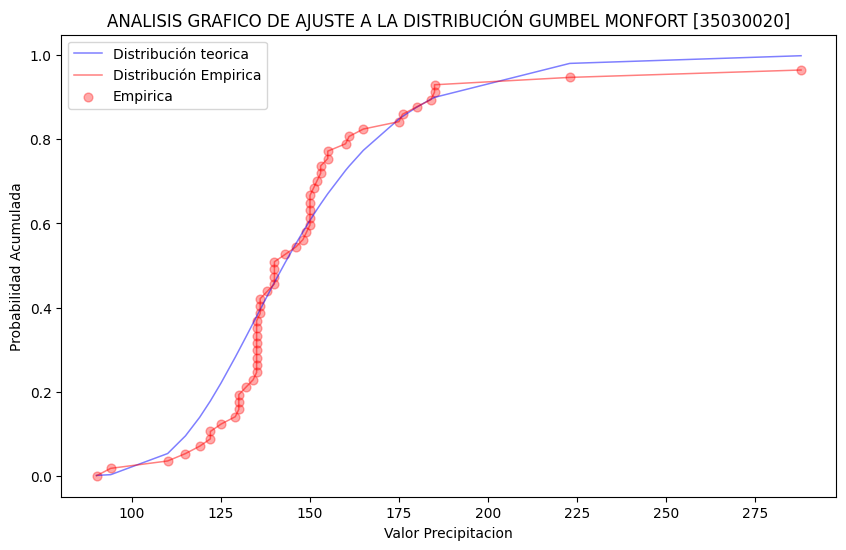

,variable,valor
0,Estacion,MONFORT [35030020]
1,Media,146.517857
2,Varianza,871.963312
3,Beta,134.312971
4,Alfa,22.535722
5,Prediccion,237.980654
6,Delta Calculado,0.141644
7,Delta Tabla,0.181738
8,Coeficiente de Determinacion,0.944818
9,Numero de Datos,56


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear los dataframes df1 y df2
df1 = pd.DataFrame({'VECTORA': VECTORA, 'PACUMULADA': PACUMULADA})
df2 = pd.DataFrame({'VECTORA': VECTORA, 'PEMPIRICA': PEMPIRICA})

# Preparación de la gráfica
plt.figure(figsize=(10, 6))

# Graficar PACUMULADA
plt.plot(df1['VECTORA'], df1['PACUMULADA'], label='Distribución teorica', color='blue', linewidth=1.1, alpha=1/2)

# Graficar PEMPIRICA
plt.plot(df2['VECTORA'], df2['PEMPIRICA'], label='Distribución Empirica', color='red', linewidth=1.1, alpha=1/2)

# Puntos de datos de PEMPIRICA
plt.scatter(df2['VECTORA'], df2['PEMPIRICA'], label='Empirica', color='red', s=40, alpha=1/3)

# Configuración de etiquetas y título
plt.title("ANALISIS GRAFICO DE AJUSTE A LA DISTRIBUCIÓN GUMBEL "+ str(estacion))
plt.xlabel("Valor Precipitacion")
plt.ylabel("Probabilidad Acumulada")
plt.legend()

# Mostrar la gráfica
plt.show()

# Crear el dataframe RESUL
RESUL = pd.DataFrame({'variable': ["Estacion","Media","Varianza", "Beta", "Alfa", "Prediccion", "Delta Calculado", "Delta Tabla", 
                                   "Coeficiente de Determinacion", "Numero de Datos"],
                      'valor': [estacion, media,varianza, miu, alfa,  VPREDICT , DELTA[0], DELTAT, RCUA, N]})

RESUL


Como se puede ver en la grafica, para la estación MONFORT [35030020], se evidencia un ajuste bueno entre las distribuciones mencionadas, lo que se corrobora por el $R^2$ que muestra un valor del $94\%$ indicando un ajuste excelente. Los valores Delta de Tabla y Calculado de la prueba de bonda de kolmorov smirnov, indican que no existe información para negar la hipotesis nula $H_0$ por lo tanto se asume que los datos  de esta estación se ajustan a la distribución Gumbel y por lo tanto la inferencia de precipitación realizada es valida.

Por ultimo guardaremos el dataset de estaciones en un formato shapefile para futuros procesos en plataformas como Gis.

In [66]:
geometry = [Point(xy) for xy in zip(estaciones['Longitud'], estaciones['Latitud'])]
gdf = gpd.GeoDataFrame(estaciones, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)
gdf.to_file("estaciones.shp")


C:\Users\davo2\AppData\Local\Temp\ipykernel_2476\1876959993.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("estaciones.shp")


### Conclusiones

- El analisis mostrados indica que los datos obtenidos pueden ser usados para diferentes procesos como crear mapas de precipitación maxima de utilidad en procesos de gestion del riesgo a desastres.
- La distribución Gumbel o de valores extremos tipo I resulta de amplia utilidad para el analisis de datos historicos de precipitación.


### Nota
El notebook aqui creado, es libre de ser ajustado segun la necesidad del interesado e igualmente esta abierto a critica constructiva en cuantoa a mejoras en el modo de analisis, metricas y metodos empleados